# Objective

The purpose of this notebook is to build different types of models and see how they perform on the same data going through the same preprocessing. Going further on this we also study the feature importances of the top performing models, one linear and one non-linear.

When building any sort of model on any data, it is important to be able to build secure and robust Data preprocessing pipelines. We achieve that objective using the sklearn Pipeline. It also makes it easy to quickly go through different types of model and run a GridSearch on them using k-folds method.

Four different models are built, Elastic Net Regression, Support Vector Machine, Decision Trees and XGBoostRegressor.

The Feature interpretation is perfromed on the ElasticNet and XGBoost models.

In [83]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import expm1
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from scipy.stats import norm, skew
from sklearn.base import BaseEstimator,TransformerMixin
from xgboost import XGBRegressor, plot_importance
from sklearn import set_config

set_config(display='diagram')


## Import Data

In [59]:
train=pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test=pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

## Correlation Matrix, Missing Values and Outlier Detection

### Correlation Matrix

<AxesSubplot:>

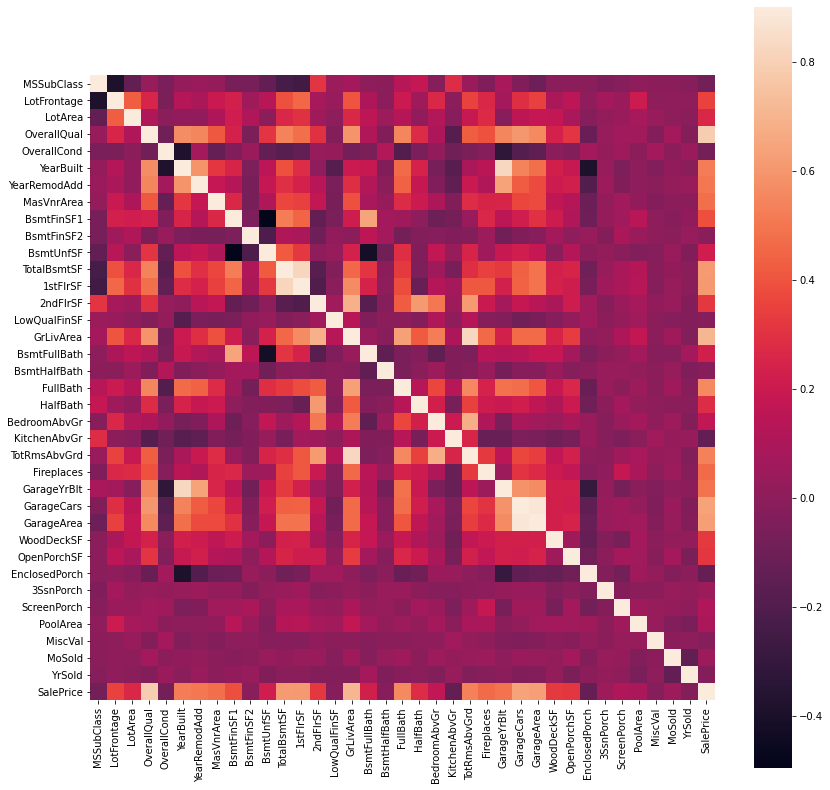

In [4]:
corrmat = train.corr()
plt.subplots(figsize=(14,14))
sns.heatmap(corrmat, vmax=0.9, square=True)

From the Correlation Matrix we find out that GrLivArea, MasVnrArea and LotFrontage are some of the variable which are highly correlated and found to have some serious outliers. 
On more investigation using boxplots and scatter plots, we see that some of the outliers of GrLivArea and LotFrontage are pulling the data in one direction too much these will be eliminated from further operations.


### Outlier Detection

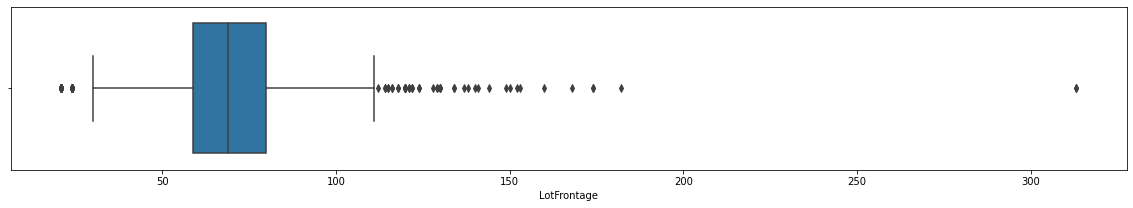

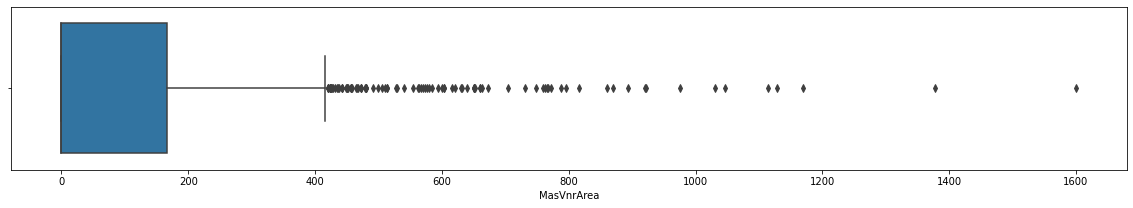

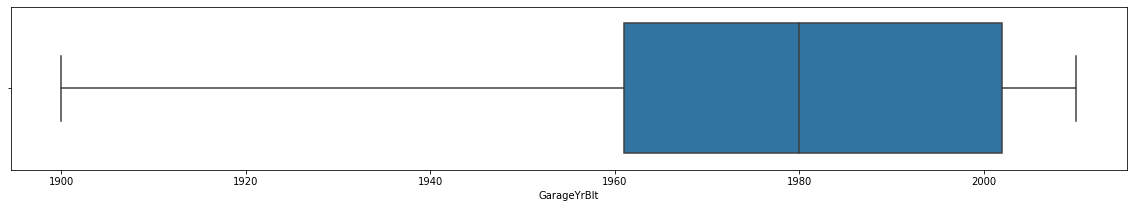

In [7]:
for column in train.columns:
    if train[column].dtype == np.float64 :
        plt.figure(figsize = (20, 3))
        ax = sns.boxplot(x = train[column])

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

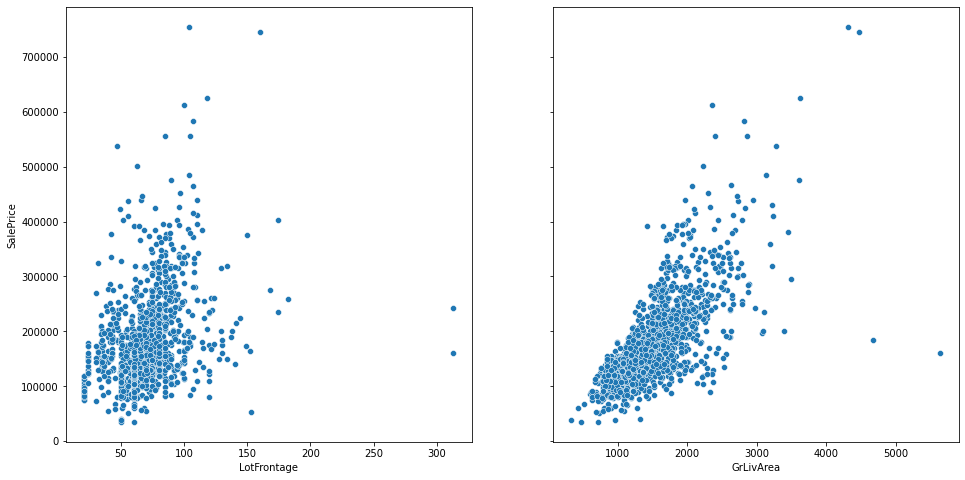

In [8]:
# plt.figure(1)
fig,ax= plt.subplots(1,2, figsize=(16,8), sharey=True)

sns.scatterplot(y=train['SalePrice'],x = train['LotFrontage'],ax=ax[0])

sns.scatterplot(y=train['SalePrice'],x = train['GrLivArea'],ax=ax[1])

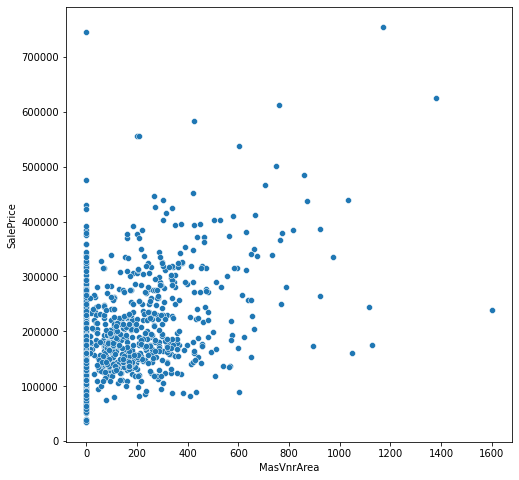

In [10]:
# Plot of the MasVnrArea
plt.figure(figsize = (8,8))
ax = sns.scatterplot(y=train['SalePrice'],x = train['MasVnrArea'])

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

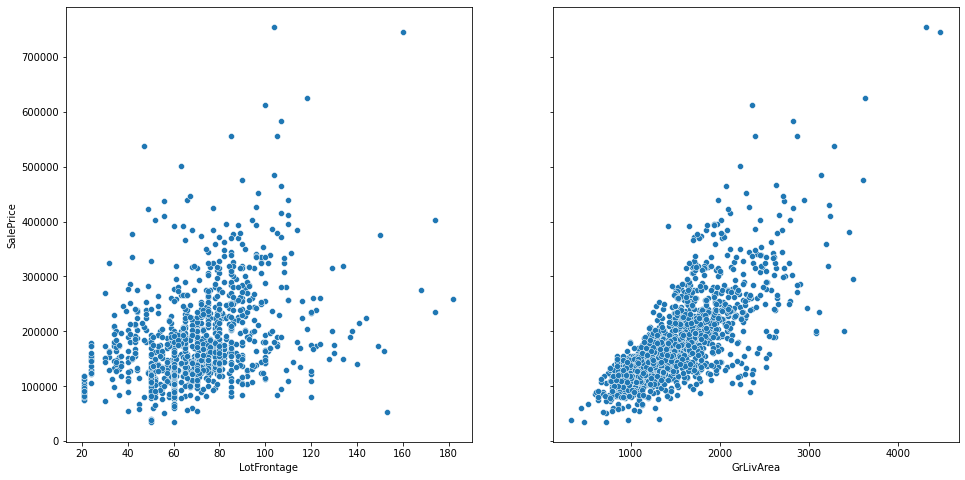

In [5]:
# Removing Outliers
train = train.drop(train[((train['GrLivArea']>4000) & (train['SalePrice']<300000)) | (train['LotFrontage']>200)].index)

# Plot to see the difference
fig,ax= plt.subplots(1,2, figsize=(16,8), sharey=True)

sns.scatterplot(y=train['SalePrice'],x = train['LotFrontage'],ax=ax[0])
sns.scatterplot(y=train['SalePrice'],x = train['GrLivArea'],ax=ax[1])

### Checking for Missing Values

In [6]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
miss_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
miss_data.head(20)

,Total,Percent
PoolQC,1451,0.995882
MiscFeature,1403,0.962938
Alley,1366,0.937543
Fence,1176,0.807138
FireplaceQu,690,0.473576
LotFrontage,259,0.177763
GarageYrBlt,81,0.055594
GarageCond,81,0.055594
GarageType,81,0.055594
GarageFinish,81,0.055594


## Target Variable Transformation

From the QQ plot and Histogram we can see that the SalePrice variable is right skewed. We will perform a log transform to fix the skewness.

The log transform makes the variable more normally distributed. This is what we will use for the further analysis.

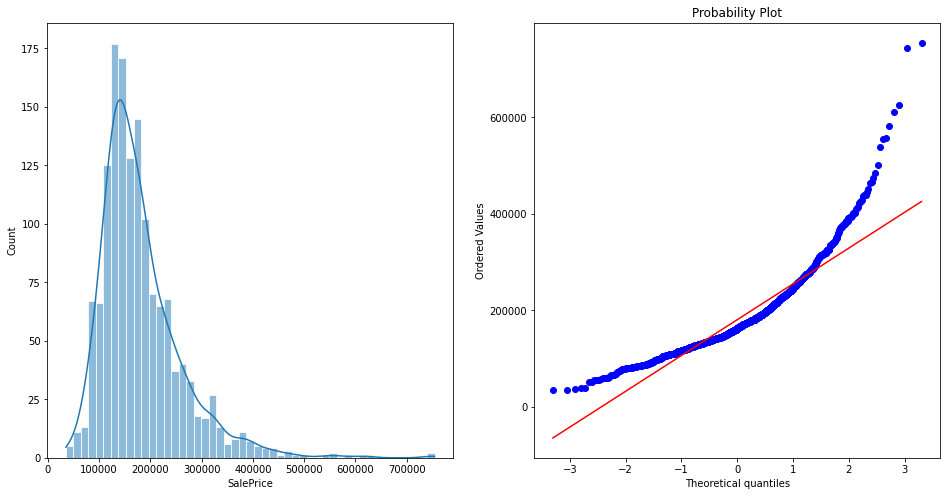

In [7]:
fig,ax= plt.subplots(1,2, figsize=(16,8))
sns.set_style('dark')
sns.histplot(train['SalePrice'], kde=True, ax=ax[0])
res = stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

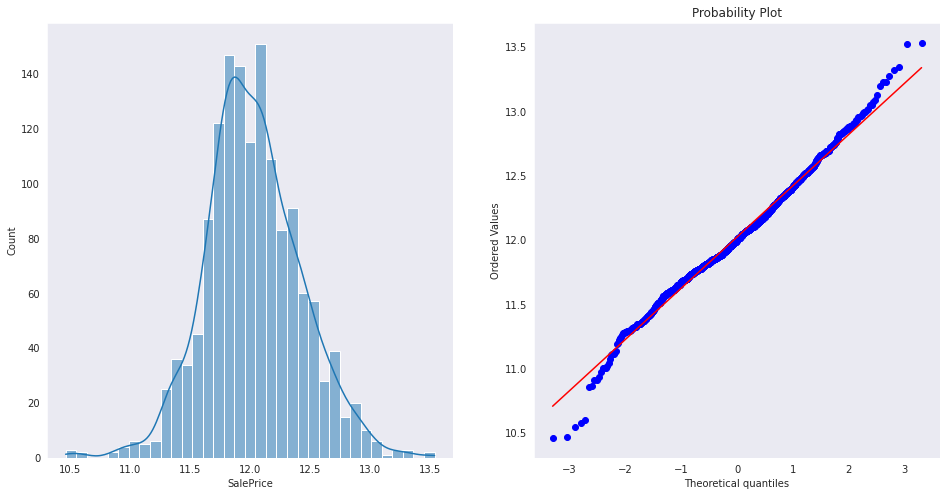

In [60]:
# Log transform on the target variable
train['SalePrice'] = np.log1p(train['SalePrice'])

fig,ax= plt.subplots(1,2, figsize=(16,8))
sns.set_style('dark')
sns.histplot(train['SalePrice'], kde=True, ax=ax[0])
res = stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

## Building a Pipeline for Data Transformation

A pipeline will be built to process the data before training. As there a lot of missing values in the original dataset, this is an attempt to make it more streamlined when testing with different models.

#### Variable Transformation ####
The variables are segregated into different categories based on how they are supposed to be transformed for the modelling. These are for imputing missing values, scaling numeric columns and also encoding the categorical variables. 

All the variables are listed below in lists which show what kind of operation will be done on them.
Categorical_columns will be processed through an Ordinal encoder to have them be used as categorical variable while modelling.
Numerical_columns will be scaled according to their statistic measures such as mean or SD. Standard Scaler of sklearn will be used.

The variables which we dont want to include in the modelling, in other words 'drop'. We dont include them in the variable lists, the ColumnTransformer automatically drops them if we specify that in **remainder** Parameter.


In [73]:
median_columns = ['LotFrontage']

mode_columns = ['MSZoning', 'Electrical', 'KitchenQual','Exterior1st','Exterior2nd','SaleType']

zero_columns = [ 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','MasVnrArea'] 
zero_cat_columns=['BsmtFullBath', 'BsmtHalfBath', 'MSSubClass']

none_columns = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
         'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

typ_columns = ['Functional']

drop_columns = ['Utilities','YrSold','MoSold','GarageYrBlt','YearBuilt','YearRemodAdd']

categorical_columns = ['Fireplaces','BldgType', 'Condition1', 'Condition2',  
                       'Foundation', 
                       'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 
                       'Neighborhood', 'RoofMatl',
                       'RoofStyle', 'SaleCondition','Street','BedroomAbvGr', 
                       'PavedDrive', 'OverallCond',
                       'CentralAir',  'ExterCond', 'ExterQual', 'FullBath',
                       'HeatingQC', 'OverallQual', 'LandSlope','LotShape','TotRmsAbvGrd']

numerical_columns = ['1stFlrSF', '2ndFlrSF', '3SsnPorch',  
        'EnclosedPorch','GrLivArea', 'HalfBath', 'KitchenAbvGr', 
        'LotArea', 'LowQualFinSF',
        'MiscVal', 'OpenPorchSF',
         'PoolArea', 'ScreenPorch', 'WoodDeckSF']

#### Pipeline ####

Since we are using Scikit-learn for the data manipulation. A very quick and reliable way to setup transformation on a dataset is to use Pipelines and then use these Pipelines in a Column Transformer to create a standard way to treat data before perfroming any kind of Data manipulation. The pipelines also prevent any sort of Data Leakage.


In [74]:
# Pipeline for each variable set that we created
# Median Pipeline
med_pipe=make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

# Mode Pipeline
mode_pipe=make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

# Zero impute Pipeline for categorical variable
zero_cat_pipe=make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

# Zero impute pipeline for Numeric variables
zero_pipe=make_pipeline(SimpleImputer(strategy='constant', fill_value=0),StandardScaler())

# Pipeline for columns imputed with None
none_pipe=make_pipeline(SimpleImputer(strategy='constant', fill_value='None'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

# Pipeline for column to be imputed with Typ
typ_pipe=make_pipeline(SimpleImputer(strategy='constant', fill_value='Typ'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))


# The column tranformer utilizing all above pipelines, while also tranforming some of the other columns
# which were not missing values
fin_encode=make_column_transformer((med_pipe,median_columns),
                                  (mode_pipe,mode_columns),
                                  (zero_pipe,zero_columns),(zero_cat_pipe,zero_cat_columns),
                                  (none_pipe, none_columns),
                                   (typ_pipe,typ_columns),
                                   (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),
                                   (StandardScaler(), numerical_columns), n_jobs=-1, remainder='drop')

##### NOTE #####
We can show this Pipeline using the train data. Notice that all these transformations are executed in parallel and not sequentially like in a Pipeline. That is the reason that when we create transformation pipeline for a column it needs to have scaling or encoding in the same pipeline. 
For example, we cannot first impute all the missing values from certain columns, and then be using those same columns for encoding in the same ColumnTransformer, since the tranformations are not occuring sequentially.


One more important thing to note while using ColumnTransformer is that the output from this is an ndarray. Which means we lose the column information such as the column name. For that reason keep a track of the columns names, we have done this using the variable lists that we created above. If we require these column names in the future use we can concatenate them in the same order they are defined in the Column Transformer.

In [13]:
disp=fin_encode.fit_transform(train)
fin_encode

ColumnTransformer(n_jobs=-1,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['LotFrontage']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1...
                                  'PavedDrive', 'OverallCond', 'CentralAir',
                                  'ExterCond', 'ExterQual', 'FullBath',
                                  'HeatingQC', 'OverallQual', 'LandSlope',
                                  'LotShape', 'TotRmsAbvGrd']),
                                ('standardscaler', StandardScaler(),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'EnclosedPorch', 'GrLivArea', 'HalfBath',
                                  'KitchenAbvGr', 'LotArea', 'LowQualFinSF',
                                  'MiscVal', 'OpenPorchSF', 'PoolArea',
                                  'ScreenPorch', 'WoodDeckSF'])])

#### Pipeline will be defined before each model construction, so that it can be used further on the test data with the fit we got from the training. ####

## Modelling

#### First the training data will be split into two parts for the purpose of building the model using CV.

In [62]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### For the Linear Model we will build a Elastic Net Regression Model ####

In [172]:
parameters = {'en__alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'en__l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
         }

elas_pipeline = Pipeline([('preprocess', fin_encode), ('en',ElasticNet())])

      
clf = GridSearchCV(elas_pipeline, parameters, scoring='r2',cv=5,verbose=1, n_jobs=-1)

grid_result = clf.fit(X_train, y_train)

print('Best R2: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)  

elasnet_model=clf.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best R2:  0.8417070459236216
Best Params:  {'en__alpha': 0.01, 'en__l1_ratio': 0.3}


##### Measuring on Test Data #####

In [173]:
y_predict = elasnet_model.predict(X_test)
print("Root Mean Squared on test data is ",(np.sqrt(mean_squared_error(y_test, y_predict))),"\n",
      "R-squared on the test data is ", r2_score(y_test, y_predict))

Root Mean Squared on test data is  0.15541450944355295 
 R-squared on the test data is  0.8705667338873958


In [30]:
# Display the Elastic Net Pipeline
elasnet_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                                                   'ExterCond', 'ExterQual',
                                                   'FullBath', 'HeatingQC',
                                                   'OverallQual', 'LandSlope',
                                                   'LotShape',
                                                   'TotRmsAbvGrd']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'EnclosedPorch',
                                                   'GrLivArea', 'HalfBath',
                                                   'KitchenAbvGr', 'LotArea',
                                                   'LowQualFinSF', 'MiscVal',
                                                   'OpenPorchSF', 'PoolArea',
                                                   'ScreenPorch',
                                                   'WoodDeckSF'])])),
                ('en', ElasticNet(alpha=0.001, l1_ratio=0.1))])

#### Using Support Vector regressor ####

The Support vector regressor will be used with the 'rbf' kernel. Grid Search CV will be used to extract the best parameters for the model.

In [180]:

svr_pipeline = Pipeline([('preprocess', fin_encode),('svr',SVR(kernel='rbf'))])

parameters = {  'svr__C': [0.1, 1, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
            'svr__gamma': [0.0001, 0.001, 0.005, 0.1]
        }


clf = GridSearchCV(svr_pipeline, parameters, scoring='r2',cv=5,verbose=1, n_jobs=-1)
grid_result = clf.fit(X_train, y_train)

print('Best R2: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)  

svr_model=clf.best_estimator_

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best R2:  0.8831988303714532
Best Params:  {'svr__C': 1, 'svr__epsilon': 0.005, 'svr__gamma': 0.001}


##### Measuring on Test Data #####

In [181]:
y_predict = svr_model.predict(X_test)
print("Root Mean Squared on test data is ",(np.sqrt(mean_squared_error(y_test, y_predict))),"\n",
      "R-squared on the test data is ", r2_score(y_test, y_predict))

Root Mean Squared on test data is  0.14173798916020408 
 R-squared on the test data is  0.8923447235177502


In [51]:
svr_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                                                   'OverallCond', 'CentralAir',
                                                   'ExterCond', 'ExterQual',
                                                   'FullBath', 'HeatingQC',
                                                   'OverallQual', 'LandSlope',
                                                   'LotShape',
                                                   'TotRmsAbvGrd']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'EnclosedPorch',
                                                   'GrLivArea', 'HalfBath',
                                                   'KitchenAbvGr', 'LotArea',
                                                   'LowQualFinSF', 'MiscVal',
                                                   'OpenPorchSF', 'PoolArea',
                                                   'ScreenPorch',
                                                   'WoodDeckSF'])])),
                ('svr', SVR(C=1, gamma=0.001))])

#### Using Decision Tree ####

In [38]:
dt_pipeline = Pipeline([('preprocess', fin_encode),('dtreg',DecisionTreeRegressor())])

parameters = {'dtreg__min_samples_split': range(2, 10)}


    
clf = GridSearchCV(dt_pipeline, parameters, scoring='r2',cv=5,verbose=1, n_jobs=-1)
grid_result = clf.fit(X_train, y_train)

print('Best R2: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)  

dt_model=clf.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best R2:  0.726544275042489
Best Params:  {'dtreg__min_samples_split': 9}


In [48]:
y_predict = dt_model.predict(X_test)
print("Root Mean Squared on test data is ",(np.sqrt(mean_squared_error(y_test, y_predict))),"\n",
      "R-squared on the test data is ", r2_score(y_test, y_predict))

Root Mean Squared on test data is  0.21951258412993868 
 R-squared on the test data is  0.7353299996269387


In [52]:
dt_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                                                   'ExterCond', 'ExterQual',
                                                   'FullBath', 'HeatingQC',
                                                   'OverallQual', 'LandSlope',
                                                   'LotShape',
                                                   'TotRmsAbvGrd']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'EnclosedPorch',
                                                   'GrLivArea', 'HalfBath',
                                                   'KitchenAbvGr', 'LotArea',
                                                   'LowQualFinSF', 'MiscVal',
                                                   'OpenPorchSF', 'PoolArea',
                                                   'ScreenPorch',
                                                   'WoodDeckSF'])])),
                ('dtreg', DecisionTreeRegressor(min_samples_split=9))])

#### Using XGBoost ####

In [182]:
xgb_pipeline = Pipeline(steps=[
                               ('preprocess',fin_encode),
                               ('xgbreg',XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1, n_jobs=-1,
                                                      booster='gbtree'))        
                              ])

# parameters={'xgbreg__max_depth':[5,10,15]}


xgb_pipeline.fit(X_train,y_train)

# clf = GridSearchCV(xgb_pipeline, parameters, scoring='r2',cv=5,verbose=1, n_jobs=-1)
# grid_result = clf.fit(X_train, y_train)

# print('Best R2: ', grid_result.best_score_)
# print('Best Params: ', grid_result.best_params_)  

# dt_model=clf.best_estimator_


Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                              colsample_bytree=1, eta=0.1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.100000001, max_delta_step=0,
                              max_depth=10, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=1000,
                              n_jobs=-1, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [183]:

y_predict = xgb_pipeline.predict(X_test)
print("Root Mean Squared on test data is ",(np.sqrt(mean_squared_error(y_test, y_predict))),"\n",
      "R-squared on the test data is ", r2_score(y_test, y_predict))

Root Mean Squared on test data is  0.14431303141641255 
 R-squared on the test data is  0.8883975097390453


## Feature Importance

For feature importance study we will be comparing between the two models. One is the elastic net and the other is XGBoost model. They are chosen as they are the best performing models on the dataset, also they differentiate in the sense that one is a linear model whereas the other is tree based method (non-linear). 

We will look at two methods to study the feature importance, one is by using the shap values and other is ICE plots.

In [143]:
# We create an array of all the feature names in the order that we get in the ColumnTransformer
feature_names=np.r_[median_columns,mode_columns,zero_columns,zero_cat_columns,none_columns,typ_columns,categorical_columns,numerical_columns]

##### Non Linear: XGBoost Pipeline #####

In [114]:
xgb_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                              colsample_bytree=1, eta=0.1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.100000001, max_delta_step=0,
                              max_depth=10, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=1000,
                              n_jobs=-1, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

 ##### Linear Model: Elastic Net Regression Pipeline #####

In [115]:
elasnet_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LotFrontage']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                                                   'ExterCond', 'ExterQual',
                                                   'FullBath', 'HeatingQC',
                                                   'OverallQual', 'LandSlope',
                                                   'LotShape',
                                                   'TotRmsAbvGrd']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'EnclosedPorch',
                                                   'GrLivArea', 'HalfBath',
                                                   'KitchenAbvGr', 'LotArea',
                                                   'LowQualFinSF', 'MiscVal',
                                                   'OpenPorchSF', 'PoolArea',
                                                   'ScreenPorch',
                                                   'WoodDeckSF'])])),
                ('en', ElasticNet(alpha=0.01, l1_ratio=0.3))])

In [185]:
xgb_pipeline[0].named_transformers_['ordinalencoder'].categories_

[array([0, 1, 2, 3]),
 array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],
       dtype=object),
 array(['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'], dtype=object),
 array(['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall'], dtype=object),
 array(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story',
        'SFoyer', 'SLvl'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object)

#### ICE(Individual conditional expectation) Plots ####

An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance that shows how the predictions change, compared to one line overall which we get in PDP(Partial dependence plots). 

In [35]:
# We will use pdpbox library to perfrom these interpretations
from pdpbox import pdp, get_dataset, info_plots

In [134]:
# Function that prints the ICE plot for the given model and variable
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

For ICE plot we must specify the numbers of similarity clusters we want, here its 24.
First we observe the interpretations for the variable 'OverallQual'.

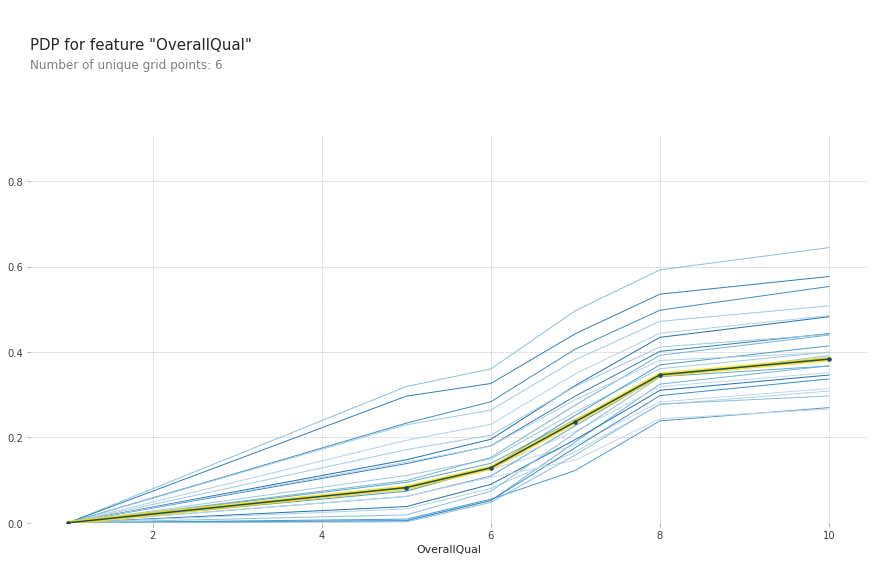

In [135]:
# For the XGBoost model on the test data
plot_pdp(xgb_pipeline,test, 'OverallQual', cluster_flag=True, nb_clusters=24, lines_flag=True)

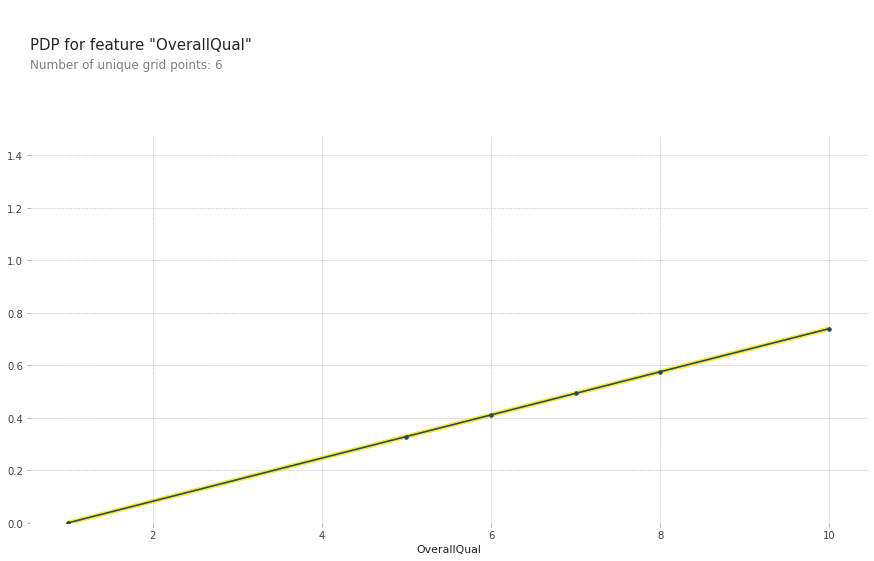

In [129]:
# For the Elastic Net model on the test data
plot_pdp(elasnet_model,test, 'OverallQual', cluster_flag=True, nb_clusters=24, lines_flag=True)

The first graph that we see is of the XGBoost model. We can see that with the increase in the OverallQual of the houses the Price also starts progressing upward. The increase is especially distinct when the OverallQual hits the 6 mark, there is a sharp increase the prices of the houses which are over that. The rest of clusters also follow the same trend which means that there are no obvious interactions that we can observe.

The second graph that we get from the Elastic Net Model, shows a linear relationship between the increase in the OverallQual and the house Sale Prices, this makes sense as its an elastic net model which models linearly.


This method is good to find out how a single feature affects the target variable but we cant find the importance between features just from this one graph. We need a different method for that.

#### SHAP(SHapley Additive exPlanations) Values ####

The idea of Shapely values originates from Game Theory. We can also think of it like, what is the ‘payout’ that we get from each predictor when it comes to finding the target variable or how much does the accuracy of these predictions change when that one variable in question is added to the model. We will be using SHAP which is an improvement on Shapely values.

In [164]:
import shap
shap.initjs()

In [191]:
explainer = shap.TreeExplainer(xgb_pipeline[1])
shap_values = explainer.shap_values(xgb_pipeline[0].transform(test))
X_shap = pd.DataFrame(shap_values)
X_shap.tail()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
1454,-0.004084,-0.038123,0.001190,-0.009180,0.000364,-0.001143,0.001364,-0.037596,-0.058095,-0.035573,...,-0.101305,0.002826,0.001213,-0.057694,0.000027,0.000015,-0.006208,-0.000254,-0.000765,0.001197
1455,-0.001391,-0.049640,0.000390,-0.009441,-0.000623,-0.003685,-0.000181,-0.000843,-0.058272,-0.020705,...,-0.096019,0.002808,0.002047,-0.046094,0.000038,0.000008,-0.003694,-0.000259,-0.000647,-0.000834
1456,-0.050762,0.006863,0.000103,-0.011504,-0.000365,0.000819,-0.000349,0.000445,0.029394,0.059364,...,-0.096314,-0.002044,0.001811,0.048742,0.000049,0.000010,-0.008220,-0.000394,-0.000800,0.017543
1457,0.006999,0.006587,0.000107,-0.005711,-0.000936,-0.011573,0.000447,-0.040438,-0.050101,0.000636,...,-0.094772,-0.003968,0.001518,0.012258,0.000038,-0.000154,0.006361,-0.000245,-0.000891,-0.002461
1458,-0.001183,0.005821,0.000114,-0.011897,-0.000279,-0.001620,0.000260,0.001362,0.036395,0.023370,...,0.105401,0.005339,0.002831,0.005776,0.000059,0.000026,0.003882,-0.000237,-0.000209,-0.004231


In [139]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  12.030655


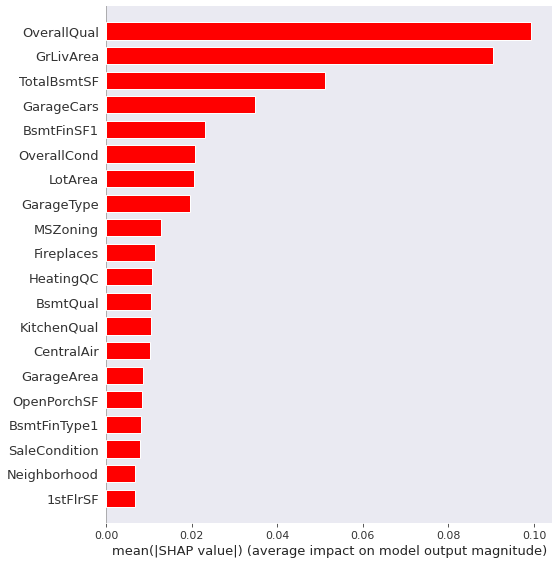

In [187]:
shap.summary_plot(shap_values, 
                  pd.DataFrame(xgb_pipeline[0].transform(test),columns=feature_names),
                  plot_type="bar", color='red')

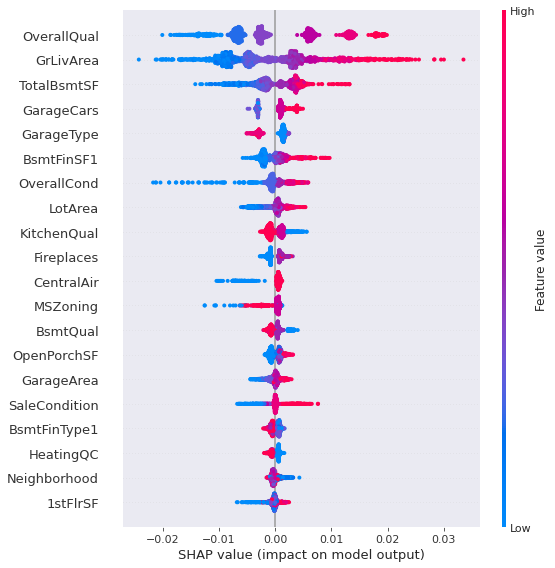

In [50]:
shap.summary_plot(shap_values, pd.DataFrame(xgb_pipeline[0].transform(test),columns=feature_names))

From the feature importance barplot above it is obvious that the variables 'OverallQual', 'GrLivArea' impact the prediction power of our model the most. 
There is also the the TotalBsmtSf variable sitting up at the top, LotArea and GarageArea. It really shows that the Overall Area of the whole house if combined will have a serious impact on the SalePrice.

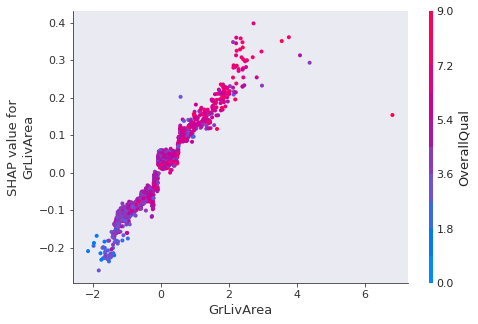

In [194]:
shap.dependence_plot(ind='GrLivArea', interaction_index='OverallQual',
                     shap_values=shap_values, 
                     features=pd.DataFrame(xgb_pipeline[0].transform(test),columns=feature_names),  
                     display_features=pd.DataFrame(xgb_pipeline[0].transform(test),columns=feature_names))

Since GrLivArea and OverallQual the most impactful variable, it might be worthwhile to see if they have any dependencies.
First lets see what this dependence plots is, 
The x-axis is the GrLivArea actual values in the dataset (for us its scaled as we used StandardScaler in the preprocessing), y-axis has the SHAP values for the same. The dots represent every instance of the value in the dataset, or simply each row in the dataset. The color gradient is the value of the feature we are comparing it with, in our case its the OverallQual.

From this graph we can clearly see an interaction between the features. As the GrLivArea increase in value so does the OverallQual as they start to become more reddish in color. This graph is great way to spot for interactions between features if one suspects that there are any, in fact its representation is more clearer than the ICE plots in many cases.

##### For the Linear Model, Elastic Net Regression ####

In [195]:
explainer = shap.LinearExplainer(elasnet_model[1],elasnet_model[0].transform(test))
shap_values = explainer.shap_values(elasnet_model[0].transform(test))
X_shap = pd.DataFrame(shap_values)

In [176]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  12.018134367535747


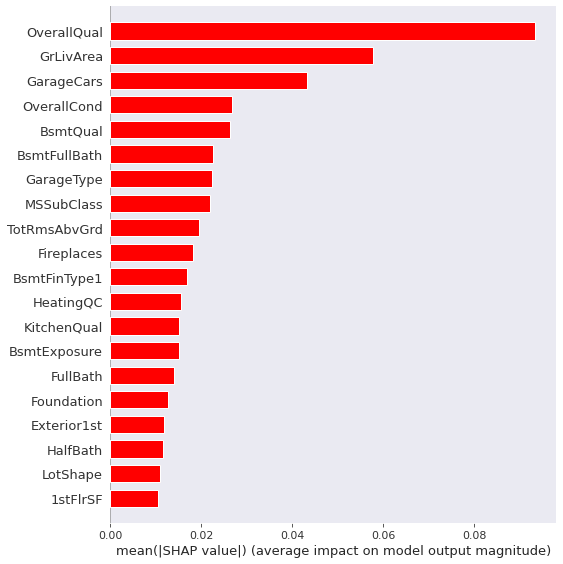

In [177]:
shap.summary_plot(shap_values, 
                  pd.DataFrame(elasnet_model[0].transform(test),columns=feature_names),
                  plot_type="bar", color='red')

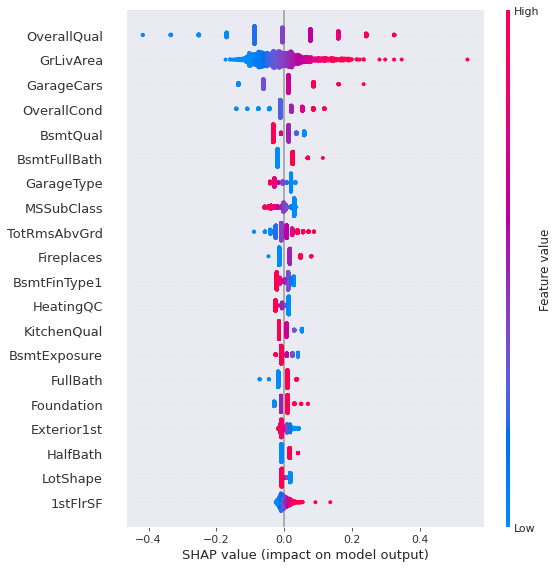

In [189]:
shap.summary_plot(shap_values, pd.DataFrame(elasnet_model[0].transform(test),columns=feature_names))

Even for the elastic net regression model, we observe that the OverallQual and the GrLivArea are the top features which impact the predictions of the model.

A thing to notice though is that how there is a difference in the SHAP value of the GrLivArea feature of the data. Its value is significantly lower when compared to the XGBoost graph that we produced earlier. Even the other features pointing towards the area of the house are less impactful in this model. 
The Categorical variables are all a lot more impactful for this model as compared the other model. This shows that numerical feature are of lower use to our model when making predicitons. It would interesting to see how much the R-square is affected when we purge some of the numeric features from the modelling.

## Predicting on the Test Dataset (Submission)

In [178]:
y_predict = xgb_pipeline.predict(test)
predict_test=expm1(y_predict)

In [ ]:
sub = pd.DataFrame({'Id': test_ID, 'SalePrice': predict_test})
sub.to_csv('submission.csv',index=False)